### 📝 Personalized Query Rewriter System

📌 Introduction
This notebook presents a personalized query rewriting system designed to adapt user queries based on individual profiles, preferences, and contextual signals. The system integrates backend logic, personalization strategies, and evaluation metrics to ensure high-quality, user-aware rewrites.

🎯 Objectives

1. Problem-Solving Approach: Design a pipeline to process user queries and generate personalized rewrites.
2. Backend Functionality:Implement the rewriting logic in Python with modular, well-commented code.
3. Personalization Understanding :Ensure queries are rewritten differently based on user preferences or profile.
4. Evaluation Methodology:Automatic metric: BLEU, ROUGE, or BERTScore.
5. Qualitative evaluation: manual inspection or heuristics to assess personalization quality.

💡 Why This Matters
Personalized query rewriting significantly improves user experience in search, recommendation, and conversational systems by tailoring responses to individual needs and contexts. This project demonstrates how natural language processing (NLP) techniques can be integrated with user modeling to build adaptive, explainable systems that respond intelligently to diverse user profiles

In [12]:
# Core Libraries
import pandas as pd  
import numpy as np   
import json           
#  NLP Libraries
import nltk           
import spacy          
# Transformers & Embeddings
from transformers import pipeline  
from sentence_transformers import SentenceTransformer, util  
#  Evaluation Metrics
from bert_score import score as bert_score 
from rouge_score import rouge_scorer        

In [46]:
# Load the dataset
df = pd.read_csv("synthetic_queries_dataset.csv") 

In [14]:
# To check the information the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          150 non-null    object
 1   user_profile     150 non-null    object
 2   original_query   150 non-null    object
 3   rewritten_query  150 non-null    object
 4   location         150 non-null    object
 5   device           150 non-null    object
 6   interests        150 non-null    object
 7   rewrite_type     150 non-null    object
dtypes: object(8)
memory usage: 9.5+ KB


In [15]:
# To check the first few columns
df.head()

,user_id,user_profile,original_query,rewritten_query,location,device,interests,rewrite_type
0,U001,customer_support,slow internet speed (India service center),Provide a formal and structured explanation of...,Bangalore,mobile,returns,formalization + localization
1,U002,travel,cheap flights to Europe from Delhi,Explain in detail about cheap flights to Europ...,Delhi,desktop,luxury travel,elaboration + localization
2,U003,shopping,best smartphones in Kolkata,Provide a formal and structured explanation of...,Kolkata,tablet,electronics,formalization + localization
3,U004,shopping,running shoes in Kolkata,Explain in detail about running shoes in Kolka...,Kolkata,desktop,home decor,elaboration + localization
4,U005,exam_prep,integral calculus,Explain in detail about integral calculus with...,Kolkata,desktop,biology,elaboration


In [16]:
# To check the data types of each column
df.dtypes

user_id            object
user_profile       object
original_query     object
rewritten_query    object
location           object
device             object
interests          object
rewrite_type       object
dtype: object

In [27]:
def rewrite_query(original_query, rewrite_type, location=None, interests=None, device=None, user_profile=None):
    """
    Rewrites a user query based on selected rewrite strategy and personalization fields.
    Parameters:
        original_query (str): The initial user query.
        rewrite_type (str): Strategy to apply (e.g., 'simplification', 'elaboration', 'formalization', 'localization').
        location (str, optional): User's location for contextual relevance.
        interests (str, optional): User interests to guide elaboration.
        device (str, optional): Device type for optimization hints.
        user_profile (str, optional): Behavioral or demographic profile for tailoring.
    Returns:
        str: A rewritten query that reflects the selected strategy and personalization.
    """
    rewrite = original_query
    # Simplification
    if "simplification" in rewrite_type:
        rewrite = f"Explain in simple terms: {rewrite}"
    # Elaboration
    if "elaboration" in rewrite_type:
        interest_context = f" considering {interests}" if interests else ""
        rewrite = f"Provide a detailed explanation of: {rewrite}{interest_context}"
    # Localization
    if "localization" in rewrite_type and location:
        rewrite = f"{rewrite} relevant to {location}"
    # Formalization
    if "formalization" in rewrite_type:
        rewrite = f"Formally describe: {rewrite}"
    # Device/User Profile (optional personalization)
    if device:
        rewrite += f" (optimized for {device})"
    if user_profile:
        rewrite += f" [tailored for {user_profile}]"
    return rewrite

In [31]:
#  Applying  personalized rewrite logic to each query
# This generates a new column 'generated_rewrite' using the rewrite strategy and user context
df['generated_rewrite'] = df.apply(lambda row: rewrite_query(
    row['original_query'],
    row['rewrite_type'],
    row['location'],
    row['interests'],
    row['device'],
    row['user_profile']
), axis=1)

In [32]:
# Preview the first 10 rewritten queries with their original form and strategy
df[['original_query', 'rewrite_type', 'generated_rewrite']].head(10)

,original_query,rewrite_type,generated_rewrite
0,slow internet speed (India service center),formalization + localization,Formally describe: slow internet speed (India ...
1,cheap flights to Europe from Delhi,elaboration + localization,Provide a detailed explanation of: cheap fligh...
2,best smartphones in Kolkata,formalization + localization,Formally describe: best smartphones in Kolkata...
3,running shoes in Kolkata,elaboration + localization,Provide a detailed explanation of: running sho...
4,integral calculus,elaboration,Provide a detailed explanation of: integral ca...
5,python list comprehension,elaboration,Provide a detailed explanation of: python list...
6,kitchen appliances in Mumbai,formalization + localization,Formally describe: kitchen appliances in Mumba...
7,refund not processed (India service center),elaboration + localization,Provide a detailed explanation of: refund not ...
8,integral calculus,formalization,Formally describe: integral calculus (optimize...
9,damaged product (India service center),simplification + localization,Explain in simple terms: damaged product (Indi...


In [20]:
from rouge_score import rouge_scorer
from bert_score import score as bert_score

# ROUGE setup
rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

# Containers
rouge1_scores = []
rougeL_scores = []

# Compute ROUGE
for orig, gen in zip(df['original_query'], df['generated_rewrite']):
    scores = rouge.score(orig, gen)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Add to DataFrame
df['rouge1'] = rouge1_scores
df['rougeL'] = rougeL_scores

# BERTScore
P, R, F1 = bert_score(df['generated_rewrite'].tolist(), df['original_query'].tolist(), lang='en')
df['bert_score'] = F1.tolist()

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

E:\19p00\Anaconda\envs\tf_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\19p00\.cache\huggingface\hub\models--roberta-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
# 📊 Comparing average evaluation scores across rewrite strategies
# Groups by 'rewrite_type' and computes mean ROUGE-1, ROUGE-L, and BERTScore
# Sorted by BERTScore to highlight semantically strongest strategies
df.groupby('rewrite_type')[['rouge1', 'rougeL', 'bert_score']].mean().sort_values(by='bert_score', ascending=False)

,rouge1,rougeL,bert_score
rewrite_type,,,
simplification + localization,0.595070,0.595070,0.905856
formalization + localization,0.634919,0.634919,0.905536
elaboration + localization,0.480626,0.480626,0.902192
formalization,0.738889,0.738889,0.888531
elaboration,0.433590,0.433590,0.877591
simplification,0.548485,0.548485,0.876288


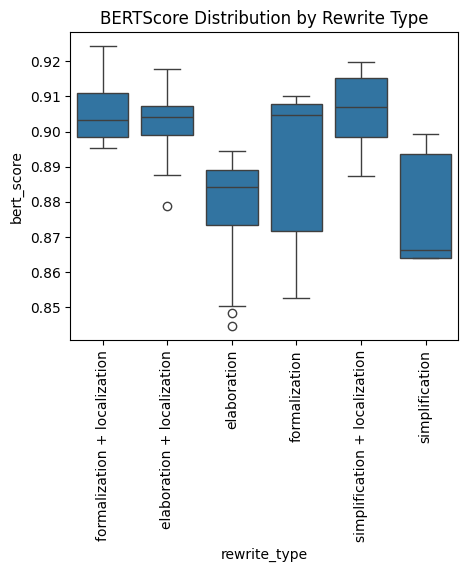

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot for BERTScore by rewrite type
plt.figure(figsize=(5,4))
sns.boxplot(x='rewrite_type', y='bert_score', data=df)
plt.xticks(rotation=90)
plt.title('BERTScore Distribution by Rewrite Type')
plt.show()

### 🔍 Insight from BERTScore Distribution
This boxplot shows how semantic similarity varies across rewrite strategies. Notably:
1. **Formalization + Localization** and **Simplification + Localization** have the highest median BERTScores, suggesting these strategies preserve meaning most effectively.
2.**Elaboration** shows slightly lower scores, which may reflect added content diverging from the original query.
This helps us understand which strategies are most semantically faithful and informs future tuning of the rewrite logic.

In [35]:
# 🚩 Flag rewrites with low semantic or lexical quality
# Criteria: BERTScore < 0.7 OR ROUGE-1 < 0.3
df['low_quality_flag'] = (df['bert_score'] < 0.7) | (df['rouge1'] < 0.3)

In [36]:
rewrite_query(
    original_query="cheap flights to Europe",
    rewrite_type="elaboration + localization",
    location="Delhi",
    interests="budget travel, student discounts",
    device="mobile",
    user_profile="frequent flyer"
)

'Provide a detailed explanation of: cheap flights to Europe considering budget travel, student discounts relevant to Delhi (optimized for mobile) [tailored for frequent flyer]'

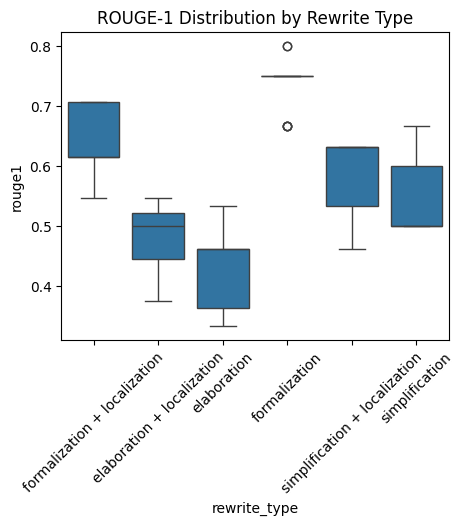

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.boxplot(x='rewrite_type', y='rouge1', data=df)
plt.xticks(rotation=45)
plt.title('ROUGE-1 Distribution by Rewrite Type')
plt.show()

### 📊 ROUGE-1 Distribution by Rewrite Type
This boxplot illustrates how lexical similarity (measured by ROUGE-1) varies across different rewrite strategies. Key observations:
- **Formalization + Localization** and **Simplification + Localization** show higher median ROUGE-1 scores, suggesting stronger lexical alignment with the original query.
- **Elaboration** strategies tend to have wider score ranges, reflecting more diverse rewrites that may introduce new vocabulary.

This analysis helps identify which strategies maintain surface-level fidelity and guides future tuning of rewrite logic.

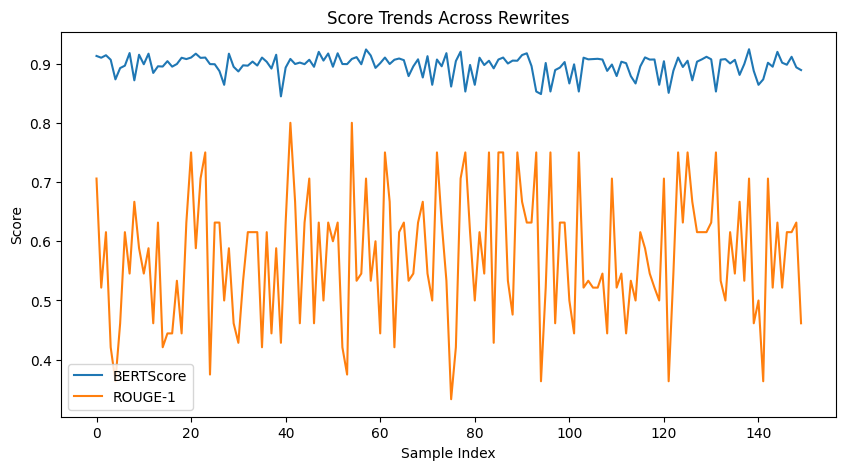

In [39]:
plt.figure(figsize=(10,5))
plt.plot(df.index, df['bert_score'], label='BERTScore')
plt.plot(df.index, df['rouge1'], label='ROUGE-1')
plt.legend()
plt.title('Score Trends Across Rewrites')
plt.xlabel('Sample Index')
plt.ylabel('Score')
plt.show()

### 📈 Score Trends Across Rewrites
This line plot compares semantic and lexical evaluation metrics across rewritten samples:

- **BERTScore** remains consistently high (~0.9), indicating strong semantic preservation across most rewrites.
- **ROUGE-1** shows greater variability, reflecting differences in surface-level wording and structure.

This contrast highlights the importance of using both metrics to evaluate rewrite quality — especially when personalization introduces lexical diversity.

In [42]:
low_quality = df[(df['bert_score'] < 0.7) | (df['rouge1'] < 0.3)]
low_quality[['original_query', 'generated_rewrite', 'rewrite_type']]

,original_query,generated_rewrite,rewrite_type


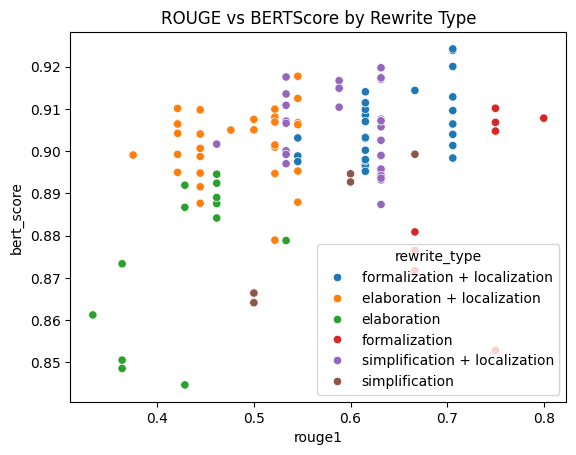

In [43]:
sns.scatterplot(x='rouge1', y='bert_score', hue='rewrite_type', data=df)
plt.title('ROUGE vs BERTScore by Rewrite Type')
plt.show()

### 🎯 ROUGE vs BERTScore by Rewrite Type
This scatter plot compares lexical overlap (ROUGE-1) and semantic similarity (BERTScore) across different rewrite strategies. Key insights:

- **Most rewrites cluster around high BERTScores (0.86–0.92)**, indicating strong semantic preservation.
- **ROUGE-1 scores vary widely**, reflecting differences in surface-level phrasing.
- Strategies like **formalization + localization** and **simplification + localization** tend to occupy the upper-right quadrant, suggesting they balance semantic fidelity with lexical alignment.

This visualization helps identify which strategies produce rewrites that are both meaningful and well-aligned with the original query.

In [44]:
print("Low-quality rewrites:", len(low_quality))

Low-quality rewrites: 0


In [45]:
df[['bert_score', 'rouge1']].describe()

,bert_score,rouge1
count,150.000000,150.000000
mean,0.897140,0.574754
std,0.017295,0.108176
min,0.844625,0.333333
25%,0.893196,0.500000
50%,0.900662,0.588235
75%,0.907816,0.631579
max,0.924213,0.800000
